# Access MERRA-2 Data from an S3 Bucket with Python
## in openscapes.2i2c.cloud/user/brianmapes/lab/
### Original authors: Chris Battisto, Alexis Hunzinger 2022
### Applied: Brian Mapes Jan 10,2024

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>This notebook <em><strong>will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook will access and plot a Modern-Era Retrospective analysis for Research and Applications (MERRA-2) zonal wind averaged over pressure and longitude, a quantity called <[U]> 

### Import Libraries

In [1]:
import requests
import xarray as xr
import s3fs
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
import pprint
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass

warnings.filterwarnings('ignore')
%matplotlib inline

### Generate .netrc file with your Earthdata Login credentials

This code generates a `.netrc` file in the `~/root/` directory of your JupyterHub space here. The `.netrc` files stores your Earthdata Login credentials, which are essential for access to GES DISC data and other NASA Earthdata collections. After you run this code cell, you will be prompted for your Earthdata Login Username and your Earthdata Login Password. Please enter them in the appropriate prompt box and press Enter.

Alternatively, you can upload a previously generated `.netrc` file to `~/root</` using the File Browser panel.



***Troubleshooting Tip***


> If you believe you have entered an incorrect username or password, you can open up a terminal instance by clicking the blue "plus" button in the top left corner, selecting "Terminal", and then remove the previously generated `.netrc` file by typing in `rm .netrc`. Then, this cell can be rerun to generate a new `.netrc` file.

In [2]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

### Get S3 Credential

A temporary credential is required to access Earthdata directly from S3. Currently each NASA DAAC requires a different credential. We will specify the endpoint for the GES DISC credential in this code cell: https://data.gesdisc.earthdata.nasa.gov/s3credentials

Here we retrieve your S3 access credential and then define an S3 direct access file system handler with S3FS. 


***Troubleshooting Tip***

>If you receive an error after running this code cell, double-check that your Earthdata Login username and password are entered correctly in your `.netrc` file, or check that you can access the following URL: https://data.gesdisc.earthdata.nasa.gov


*NOTE: This credential expires after one hour, and the below code cell will need to be rerun if time expires.*

In [3]:
auth_link = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials

def begin_s3_direct_access(url: str=auth_link):
    print(auth_link)
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'])

# gesdisc_fs = begin_s3_direct_access()
fs = begin_s3_direct_access()

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(fs)

https://data.gesdisc.earthdata.nasa.gov/s3credentials


s3fs.core.S3FileSystem

------------------------
# OPEN MULTIFILE 3-HOURLY MERRA2 DATASET IN XARRAY 

In [4]:
fs.ls('s3://gesdisc-cumulus-prod-protected/MERRA2/')

['gesdisc-cumulus-prod-protected/MERRA2/M2I1NXASM.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I1NXINT.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I1NXLFO.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NVAER.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NVASM.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NVCHM.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NVGAS.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NXGAS.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I6NPANA.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I6NVANA.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2SDNXSLV.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXADG.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXAER.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXCHM.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXCSP.5.12.4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXFLX.5.12.4

In [5]:
fs.ls('s3://gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06') # No Wildcards!

['gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230601.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230602.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230603.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230604.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230605.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230606.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230607.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230608.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230609.nc4',
 'gesdisc-cumulus-prod-protected/MERR

In [6]:
# a list of files (all days in a month, ASM dataset with U in it) 
flist = fs.ls('s3://gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06')
#ds = xr.open_mfdataset([fs.open(f) for f in flist], decode_cf=True)

In [7]:
# One File 
fname = 'gesdisc-cumulus-prod-protected/MERRA2/M2I3NPASM.5.12.4/2023/06/MERRA2_400.inst3_3d_asm_Np.20230601.nc4'
ds = xr.open_dataset(fs.open(fname), decode_cf=True)

In [8]:
ds

<xarray.Dataset>
Dimensions:  (lon: 576, lat: 361, lev: 42, time: 8)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
  * time     (time) datetime64[ns] 2023-06-01 ... 2023-06-01T21:00:00
Data variables: (12/14)
    EPV      (time, lev, lat, lon) float32 ...
    H        (time, lev, lat, lon) float32 ...
    O3       (time, lev, lat, lon) float32 ...
    OMEGA    (time, lev, lat, lon) float32 ...
    PHIS     (time, lat, lon) float32 ...
    PS       (time, lat, lon) float32 ...
    ...       ...
    QV       (time, lev, lat, lon) float32 ...
    RH       (time, lev, lat, lon) float32 ...
    SLP      (time, lat, lon) float32 ...
    T        (time, lev, lat, lon) float32 ...
    U        (time, lev, lat, lon) float32 ...
    V        (time, lev, lat, lon) float32 ...
Attributes: (12/30)
    History:                           Original file generated: Mon Jun 12 14...
    Comment:                           GMAO filename: d5124_m2_jan10.inst3_3d...
    Filename:                          MERRA2_400.inst3_3d_asm_Np.20230601.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/QBZ6MG944HW0
    RangeBeginningDate:                2023-06-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2023-06-01
    RangeEndingTime:                   21:00:00.000000

In [15]:
dp = -ds.lev.diff(dim='lev')
dp

<xarray.DataArray 'lev' (lev: 41)>
array([25.        , 25.        , 25.        , 25.        , 25.        ,
       25.        , 25.        , 25.        , 25.        , 25.        ,
       25.        , 25.        , 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 30.        ,
       20.        , 10.        , 10.        , 10.        , 10.        ,
        3.        ,  2.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.30000001,  0.19999999,  0.09999999,  0.09999999,
        0.20000001])
Coordinates:
  * lev      (lev) float64 975.0 950.0 925.0 900.0 875.0 ... 0.7 0.5 0.4 0.3 0.1

In [16]:
# Multiply by dp*100/9.8 and sum it up for integrated momentum. Broadcasting works!

Udp_overg = ds.U * dp*100/9.8

Udp_overg

<xarray.DataArray (time: 8, lev: 41, lat: 361, lon: 576)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-3.79860219e+02, -3.63418095e+02, -3.46975971e+02, ...,
          -4.28626063e+02, -4.12433062e+02, -3.96177781e+02],
         [-2.49132894e+02, -2.29646798e+02, -2.10100367e+02, ...,
          -3.07240839e+02, -2.87933800e+02, -2.68548909e+02],
         [-3.77742672e+02, -3.55321595e+02, -3.32838236e+02, ...,
          -4.44569940e+02, -4.22335705e+02, -4.00101469e+02]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
         [-8.30368557e+00, -8.17613456e+00, -8.04061161e+00, ...,
          -8.70228248e+00, -8.57473147e+00, -8.43920852e+00],
         [-6.32664487e+00, -6.19112192e+00, -6.05559897e+00, ...,
          -6.72524179e+00, -6.58971883e+00, -6.46216782e+00],
         [-5.80846888e+00, -5.67294593e+00, -5.53742298e+00, ...,
          -6.20706580e+00, -6.07951478e+00, -5.94399183e+00]],

        [[-1.95892695e+00, -2.48507493e+00, -3.01122292e+00, ...,
          -3.88454925e-01, -9.06630972e-01, -1.43277896e+00],
         [ 4.05191520e+00,  3.49387946e+00,  2.94381566e+00, ...,
           5.69413468e+00,  5.15204281e+00,  4.60197901e+00],
         [ 9.84751500e+00,  9.25759150e+00,  8.65969606e+00, ...,
           1.16093136e+01,  1.10233760e+01,  1.04374385e+01],
         ...,
         [-1.97044636e+01, -1.97044636e+01, -1.97044636e+01, ...,
          -1.96885197e+01, -1.97044636e+01, -1.97044636e+01],
         [-1.51285705e+01, -1.51126266e+01, -1.51126266e+01, ...,
          -1.51764021e+01, -1.51604582e+01, -1.51445144e+01],
         [-1.31196418e+01, -1.31036979e+01, -1.30877541e+01, ...,
          -1.31674734e+01, -1.31515296e+01, -1.31355857e+01]]]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 975.0 950.0 925.0 900.0 875.0 ... 0.7 0.5 0.4 0.3 0.1
  * time     (time) datetime64[ns] 2023-06-01 ... 2023-06-01T21:00:00

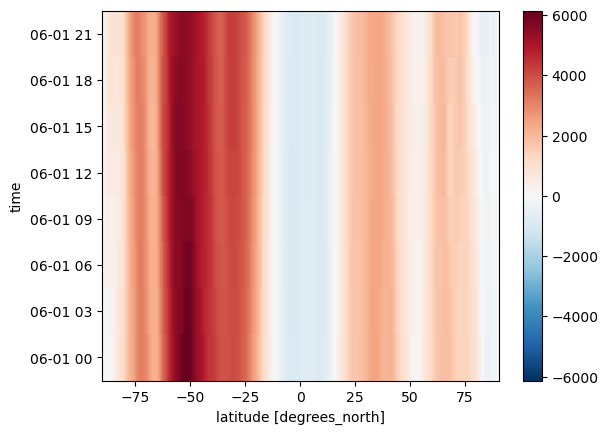

In [17]:
# Vertically averaged and zonally averaged! 

Udp_overg.mean(dim=['lon','lev']).plot()

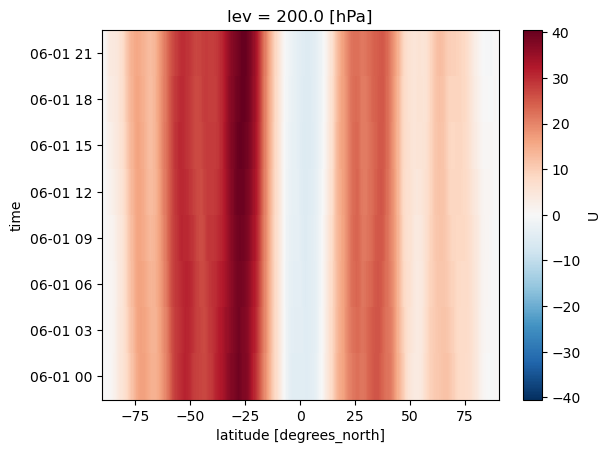

In [13]:
ds.U.mean(dim='lon').sel(lev=200).plot()